# MA cencus block and town join, basic geospatial EDA

### Goals:
* matching different geospatial systems/crs across files using shapefiles - join the census block and towns
* derive the x and y coordinates for each town for modeling from the shapefile (centroid)


### Accomplishments:
* Derived latitude and longitude of the centroid of each of the 351 towns/municipalities in the MA opioid overdose dataset to use as the geospatial component when building a model.
* Joined towns (351 towns/cities in the MA opioid overdose dataset) and 2010 census blocks to pull in the American Community Survey demographics data and use it as predictors of opioid overdose deaths per year per town.
* Explored the merge error by comparing the 2010 population counts from the town survey shapefile and the sum after merge of the 2010 population counts from the census block shapefile


### Outputs:
* data/tidy_data/ma_town_crs4326_coords.csv  - MA tows with centroid x/y points for modeling
* data/tidy_data/census_block_town_match.csv - association of MA towns with 2010 census blocks (for ACS data merge) - not perfect, some errors, but will go with this
* data/tidy_data/census_block_town_match_2010pop_error.csv - 2010 population count errors after centroid census block and town survey join 
* pdf notebook report: products/notebook_3_ma_census_block_and_town_match.pdf

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import geoplot
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
death_data = pd.read_csv("../../data/tidy_data/ma_town_opioid_overdose_death_by_place_of_death_2014_to_2018.csv")
# census blocks map
census_blocks = gpd.read_file("../../data/raw_data/shapefiles_and_geography_related/CENSUS2010_BLK_BG_TRCT_SHP/CENSUS2010BLOCKGROUPS_POLY.shp")
town_map = gpd.read_file("../../data/raw_data/shapefiles_and_geography_related/townssurvey_shp/TOWNSSURVEY_POLYM.shp")
town_map_alt = gpd.read_file("../../data/raw_data/shapefiles_and_geography_related/townssurvey_shp/TOWNSSURVEY_POLY.shp")

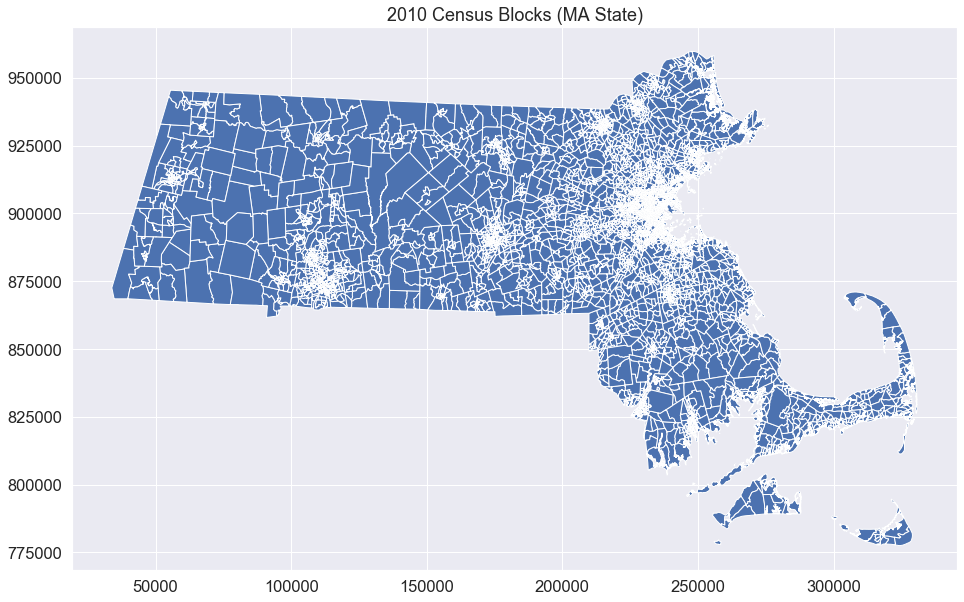

In [3]:
census_blocks.plot(figsize=(16,10))
plt.title("2010 Census Blocks (MA State)")
plt.show()

Is there a visual difference between the 2 town border survey shapefiles?

(351, 17)


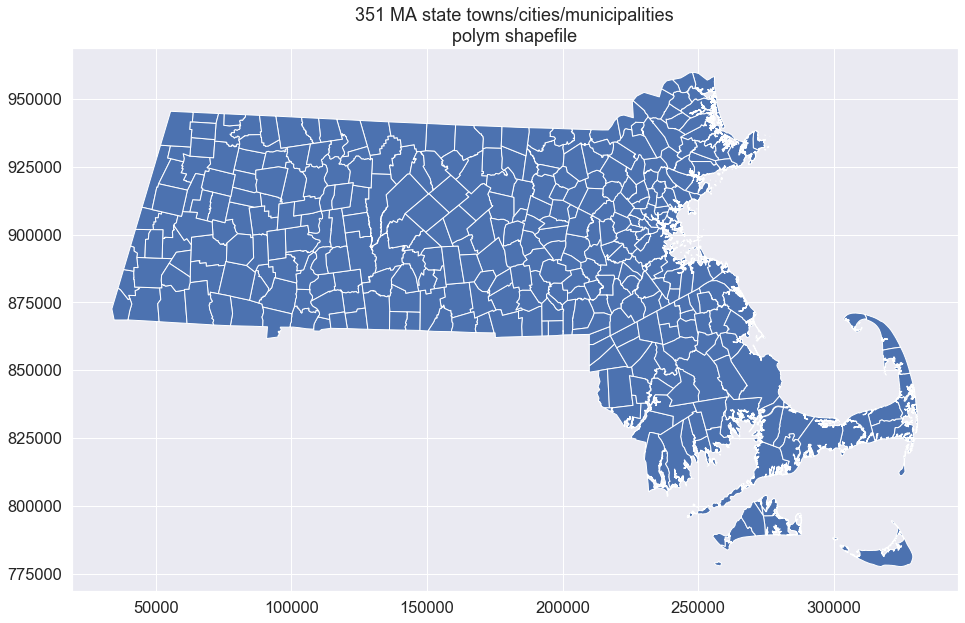

In [4]:
print(town_map.shape)
town_map.plot(figsize=(16,10))
plt.title("351 MA state towns/cities/municipalities\npolym shapefile")
plt.show()

(1243, 23)


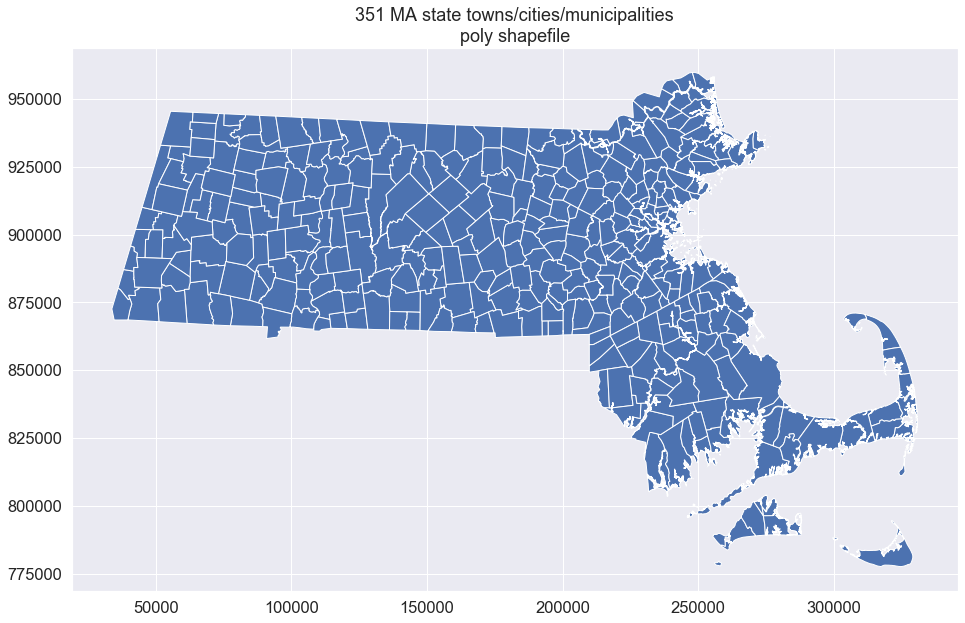

In [5]:
print(town_map_alt.shape)
town_map_alt.plot(figsize=(16,10))
plt.title("351 MA state towns/cities/municipalities\npoly shapefile")
plt.show()

More rows in the poly shapefile (vs the polyM), but maps look the same?

In [6]:
# what's inside the shapefiles?
print(census_blocks.columns)
census_blocks.head()

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLKGRPCE10', 'GEOID10',
       'NAMELSAD10', 'MTFCC10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'AREA_SQFT', 'AREA_ACRES', 'POP100_RE', 'HU100_RE',
       'LOGPL94171', 'LOGSF1', 'LOGACS0610', 'LOGSF1C', 'SHAPE_AREA',
       'SHAPE_LEN', 'geometry'],
      dtype='object')


,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,023,525104,2,250235251042,Block Group 2,G5030,2648651.0,119260.0,+41.9751132,...,683.9256,1120,404,0159334,137632,0007882,0137632,2.767760e+06,8963.749528,"POLYGON ((245073.4579000026 857943.9572999999,..."
1,25,023,525104,4,250235251044,Block Group 4,G5030,4625818.0,11563.0,+41.9677679,...,1145.8539,2178,690,0159336,137634,0007884,0137634,4.637125e+06,9555.602586,"POLYGON ((242521.254900001 859747.8350999989, ..."
2,25,023,525203,1,250235252031,Block Group 1,G5030,2367037.0,62136.0,+42.0051872,...,600.2231,1540,527,0159338,137636,0007885,0137636,2.429027e+06,9226.194871,"POLYGON ((244276.8404999971 862120.2314999998,..."
3,25,023,510100,2,250235101002,Block Group 2,G5030,686351.0,0.0,+42.1115078,...,169.5890,1172,414,0159161,137459,0007745,0137459,6.863050e+05,3338.839737,"POLYGON ((241369.4518999979 874137.570700001, ..."
4,25,023,510100,3,250235101003,Block Group 3,G5030,403906.0,0.0,+42.1115626,...,99.8001,792,290,0159162,137460,0007746,0137460,4.038783e+05,3178.436538,"POLYGON ((240747.7463999987 873189.6048000008,..."


In [7]:
print(town_map.columns)
print(town_map_alt.columns)
town_map.head()

Index(['TOWN', 'TOWN_ID', 'POP1980', 'POP1990', 'POP2000', 'POPCH80_90',
       'POPCH90_00', 'TYPE', 'FOURCOLOR', 'FIPS_STCO', 'SUM_ACRES',
       'SUM_SQUARE', 'POP2010', 'POPCH00_10', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry'],
      dtype='object')
Index(['TOWN', 'TOWN_ID', 'POP1980', 'POP1990', 'POP2000', 'POPCH80_90',
       'POPCH90_00', 'TYPE', 'ISLAND', 'COASTAL_PO', 'FOURCOLOR', 'FIPS_STCO',
       'CCD_MCD', 'FIPS_PLACE', 'FIPS_MCD', 'FIPS_COUNT', 'ACRES',
       'SQUARE_MIL', 'POP2010', 'POPCH00_10', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry'],
      dtype='object')


,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,SUM_ACRES,SUM_SQUARE,POP2010,POPCH00_10,SHAPE_Leng,SHAPE_Area,geometry
0,WELLESLEY,317,26658,26615,26604,-43,-11,T,2,25021,6749.852,10.547,27982,1378,26738.594369,2.726958e+07,"(POLYGON ((219129.012500003 897474.7045999989,..."
1,NEEDHAM,199,27310,27557,28924,247,1367,T,4,25021,8130.187,12.703,28886,-38,28960.012825,3.294777e+07,"POLYGON ((222991.1424999982 895149.4145999998,..."
2,PETERSHAM,234,997,1131,1180,134,49,T,3,25027,43675.599,68.243,1234,54,73405.706629,1.767489e+08,"POLYGON ((150592.6525000036 914968.5846000016,..."
3,READING,246,22545,22539,23708,-6,1169,T,3,25017,6393.727,9.990,24747,1039,23126.471303,2.587450e+07,"POLYGON ((232551.0625 923891.9946000017, 23344..."
4,QUINCY,243,83682,84985,88025,1303,3040,C,3,25021,11080.397,17.313,92271,4246,87188.934275,4.484078e+07,"(POLYGON ((242254.612499997 895020.5045999996,..."


In [8]:
# does this column denote state?
len(set(census_blocks['STATEFP10']))
# A: yes - all from one state

1

## Towns shapefile EDA
* do the town names match between the opioid overdose death data and the MA towns survey shapefile?
* derive the x and y coordinates of each town for modeling

In [9]:
town_map['TOWN'] = town_map['TOWN'].str.lower()
len(set(town_map['TOWN']))

351

In [10]:
print(set(town_map['TOWN']) - set(death_data['city_death']))
print(set(death_data['city_death']) - set(town_map['TOWN']))

{'north attleborough'}
{'north attleboro'}


In [11]:
# fix name
death_data['city_death'] = death_data['city_death'].replace('north attleboro', 'north attleborough')

In [12]:
town_test_merge = town_map.merge(death_data, how='left', left_on='TOWN', right_on='city_death')

In [13]:
print(len(set(town_test_merge['TOWN'])))
print(len(set(town_test_merge['city_death'])))
print(sum(town_test_merge['TOWN'] == town_test_merge['city_death']))
# able to merge without problems

351
351
351


In [14]:
town_test_merge

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,...,POPCH00_10,SHAPE_Leng,SHAPE_Area,geometry,city_death,2014,2015,2016,2017,2018
0,wellesley,317,26658,26615,26604,-43,-11,T,2,25021,...,1378,26738.594369,2.726958e+07,"(POLYGON ((219129.012500003 897474.7045999989,...",wellesley,0,1,0,0,0
1,needham,199,27310,27557,28924,247,1367,T,4,25021,...,-38,28960.012825,3.294777e+07,"POLYGON ((222991.1424999982 895149.4145999998,...",needham,0,1,2,1,0
2,petersham,234,997,1131,1180,134,49,T,3,25027,...,54,73405.706629,1.767489e+08,"POLYGON ((150592.6525000036 914968.5846000016,...",petersham,0,0,0,0,0
3,reading,246,22545,22539,23708,-6,1169,T,3,25017,...,1039,23126.471303,2.587450e+07,"POLYGON ((232551.0625 923891.9946000017, 23344...",reading,2,2,4,4,1
4,quincy,243,83682,84985,88025,1303,3040,C,3,25021,...,4246,87188.934275,4.484078e+07,"(POLYGON ((242254.612499997 895020.5045999996,...",quincy,39,43,36,37,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,somerville,274,75836,76210,77478,374,1268,C,4,25017,...,-1724,19884.219455,1.069865e+07,"POLYGON ((230662.7124999985 907352.6845999993,...",somerville,14,15,19,12,8
347,pembroke,231,13882,14544,16927,662,2383,T,4,25023,...,910,42341.724263,6.100547e+07,"POLYGON ((259609.4624999985 874160.1746000014,...",pembroke,3,2,5,1,0
348,duxbury,82,13174,13895,14248,721,353,T,1,25023,...,811,99884.166652,6.232911e+07,(POLYGON ((266547.2325000018 868791.5045999996...,duxbury,0,0,2,0,0
349,boxford,38,5751,6266,7921,515,1655,T,3,25009,...,44,44884.884100,6.321618e+07,"POLYGON ((233567.7524999976 943010.8845999986,...",boxford,0,0,0,0,0


In [15]:
# convert geometry to a more recognizable crs format
town_test_merge['geometry'] = town_test_merge['geometry'].to_crs(epsg=4326)
town_test_merge.head()

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,...,POPCH00_10,SHAPE_Leng,SHAPE_Area,geometry,city_death,2014,2015,2016,2017,2018
0,wellesley,317,26658,26615,26604,-43,-11,T,2,25021,...,1378,26738.594369,2.726958e+07,"(POLYGON ((-71.26791296846598 42.327527799305,...",wellesley,0,1,0,0,0
1,needham,199,27310,27557,28924,247,1367,T,4,25021,...,-38,28960.012825,3.294777e+07,POLYGON ((-71.22114734819833 42.30648947704145...,needham,0,1,2,1,0
2,petersham,234,997,1131,1180,134,49,T,3,25027,...,54,73405.706629,1.767489e+08,POLYGON ((-72.10093262757198 42.48368711606084...,petersham,0,0,0,0,0
3,reading,246,22545,22539,23708,-6,1169,T,3,25017,...,1039,23126.471303,2.587450e+07,POLYGON ((-71.10357918791566 42.56490520777559...,reading,2,2,4,4,1
4,quincy,243,83682,84985,88025,1303,3040,C,3,25021,...,4246,87188.934275,4.484078e+07,(POLYGON ((-70.98752024993465 42.3045244458064...,quincy,39,43,36,37,35


Need the town centroids for modeling - derive it here:

In [16]:
ma_town_coord = pd.DataFrame({'town':town_test_merge['TOWN'].copy(), 'x': town_test_merge.centroid.x, 'y': town_test_merge.centroid.y})
ma_town_coord.head()

,town,x,y
0,wellesley,-71.285441,42.304304
1,needham,-71.241078,42.281368
2,petersham,-72.221072,42.459687
3,reading,-71.105574,42.535054
4,quincy,-71.020353,42.250488


In [17]:
### write to csv:
#ma_town_coord.to_csv("../../data/tidy_data/ma_town_crs4326_coords.csv", index=False)

## Census block and Towns join

In [18]:
town_map.head()

,TOWN,TOWN_ID,POP1980,POP1990,POP2000,POPCH80_90,POPCH90_00,TYPE,FOURCOLOR,FIPS_STCO,SUM_ACRES,SUM_SQUARE,POP2010,POPCH00_10,SHAPE_Leng,SHAPE_Area,geometry
0,wellesley,317,26658,26615,26604,-43,-11,T,2,25021,6749.852,10.547,27982,1378,26738.594369,2.726958e+07,"(POLYGON ((219129.012500003 897474.7045999989,..."
1,needham,199,27310,27557,28924,247,1367,T,4,25021,8130.187,12.703,28886,-38,28960.012825,3.294777e+07,"POLYGON ((222991.1424999982 895149.4145999998,..."
2,petersham,234,997,1131,1180,134,49,T,3,25027,43675.599,68.243,1234,54,73405.706629,1.767489e+08,"POLYGON ((150592.6525000036 914968.5846000016,..."
3,reading,246,22545,22539,23708,-6,1169,T,3,25017,6393.727,9.990,24747,1039,23126.471303,2.587450e+07,"POLYGON ((232551.0625 923891.9946000017, 23344..."
4,quincy,243,83682,84985,88025,1303,3040,C,3,25021,11080.397,17.313,92271,4246,87188.934275,4.484078e+07,"(POLYGON ((242254.612499997 895020.5045999996,..."


### Joining the geometries directly: 

In [19]:
# how does the intersects option do?
intersects_join = gpd.sjoin(town_map, census_blocks, how='left', op='intersects')

In [20]:
# original number of towns:
print(town_map.shape)
# number of towns in the intersects join:
print(len(set(intersects_join['TOWN'])))
print(census_blocks.shape)
print(intersects_join.shape)
print(len(set(intersects_join['GEOID10'])))
intersects_join['GEOID10'].value_counts()

(351, 17)
351
(4979, 22)
(8697, 39)
4979


250110401004    10
250158227003     9
250110406003     9
250039313001     8
250158227002     8
                ..
250173703005     1
250235113015     1
250173575002     1
250214131005     1
250039352002     1
Name: GEOID10, Length: 4979, dtype: int64

In [21]:
intersects_join_alt = gpd.sjoin(town_map_alt, census_blocks, how='left', op='intersects')
# original number of towns:
print(town_map_alt.shape)
# number of towns in the intersects join:
print(len(set(intersects_join_alt['TOWN'])))
print(census_blocks.shape)
print(intersects_join_alt.shape)
print(len(set(intersects_join_alt['GEOID10'])))
intersects_join_alt['GEOID10'].value_counts()

(1243, 23)
351
(4979, 22)
(9932, 45)
4980


250092221001    28
250056461042    21
250235062033    21
250092691002    21
250092701001    21
                ..
250056102043     1
250251401021     1
250158202031     1
250039001001     1
250056140002     1
Name: GEOID10, Length: 4979, dtype: int64

Join even messier with the poly shapefile (vs the polyM) - try the other `op` join options:

In [22]:
# how does the within option do?
within_join = gpd.sjoin(town_map, census_blocks, how='left', op='within')
# original number of towns:
print(town_map.shape)
# number of towns in the within join:
print(len(set(within_join['TOWN'])))
print(census_blocks.shape)
print(within_join.shape)
print(len(set(within_join['GEOID10'])))
within_join['GEOID10'].value_counts()

(351, 17)
351
(4979, 22)
(351, 39)
1


Series([], Name: GEOID10, dtype: int64)

In [23]:
# how does the contains option do?
contains_join = gpd.sjoin(town_map, census_blocks, how='left', op='contains')
# original number of towns:
print(town_map.shape)
# number of towns in the contains join:
print(len(set(contains_join['TOWN'])))
print(census_blocks.shape)
print(contains_join.shape)
print(len(set(contains_join['GEOID10'])))
contains_join['GEOID10'].value_counts()

(351, 17)
351
(4979, 22)
(2608, 39)
2467


250092173002    1
250173537005    1
250251701007    1
250138013004    1
250214132004    1
               ..
250173323004    1
250250604004    1
250214203013    1
250138004001    1
250138009003    1
Name: GEOID10, Length: 2466, dtype: int64

### Notes:
* intersects - assigns census blocks to too many towns
* within - terrible
* contains - too many census blocks lost

### Alternative geometry joining strategy: 
* convert the geometry of the census blocks to points (centroids) - join using contains (no need to worry about borders and geometry overlap) 
* check how well this join works by comparing 2010 population totals by town

In [24]:
centroid_blocks = census_blocks.copy()
# change geometry 
centroid_blocks['geometry'] = centroid_blocks['geometry'].centroid
print(centroid_blocks.shape)
centroid_blocks['geometry'].head()

(4979, 22)


0    POINT (243856.7307279073 858308.2978385694)
1    POINT (242004.2566174036 857829.7623223617)
2    POINT (244160.0989660571 861561.0733446195)
3    POINT (241130.6851021084 873574.4539211198)
4     POINT (240478.7043746133 873576.766094962)
Name: geometry, dtype: object

Centroid shape file still has the same data, but the geometry is different - switched from polygon to point geometries.

Map plot of result:

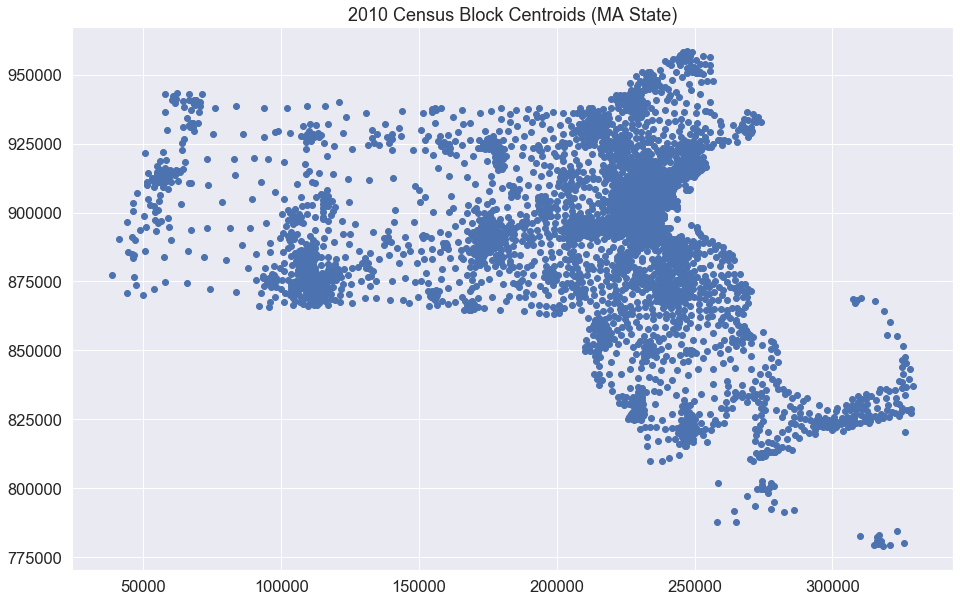

In [25]:
centroid_blocks.plot(figsize=(16,10))
plt.title("2010 Census Block Centroids (MA State)")
plt.show()

In [26]:
cent_join = gpd.sjoin(town_map, centroid_blocks, how='left', op='contains')
# number of towns in the contains join:
print(len(set(cent_join['TOWN'])))
print(census_blocks.shape)
print(cent_join.shape)
print(len(set(cent_join['GEOID10'])))
cent_join['GEOID10'].value_counts()

351
(4979, 22)
(4958, 39)
4955


250092173002    1
250138136013    1
250010120013    1
250056405004    1
250173538004    1
               ..
250235453003    1
250235201001    1
250250404011    1
250056509003    1
250138016041    1
Name: GEOID10, Length: 4954, dtype: int64

In [27]:
print(len(set(census_blocks['GEOID10'])))
print(len(set(cent_join['GEOID10'])))

4979
4955


In [28]:
cent_join_inter = gpd.sjoin(town_map, centroid_blocks, how='left', op='intersects')
# number of towns in the contains join:
print(len(set(cent_join_inter['TOWN'])))
print(census_blocks.shape)
print(cent_join_inter.shape)
print(len(set(cent_join_inter['GEOID10'])))
cent_join_inter['GEOID10'].value_counts()

351
(4979, 22)
(4958, 39)
4955


250092173002    1
250138136013    1
250010120013    1
250056405004    1
250173538004    1
               ..
250235453003    1
250235201001    1
250250404011    1
250056509003    1
250138016041    1
Name: GEOID10, Length: 4954, dtype: int64

In [29]:
cent_join_within = gpd.sjoin(town_map, centroid_blocks, how='left', op='within')
# number of towns in the contains join:
print(len(set(cent_join_within['TOWN'])))
print(census_blocks.shape)
print(cent_join_within.shape)
print(len(set(cent_join_within['GEOID10'])))
cent_join_within['GEOID10'].value_counts()

351
(4979, 22)
(351, 39)
1


Series([], Name: GEOID10, dtype: int64)

For the centroid join:
* within not a good option
* contains and intersects give similar results - go with the contains option
* lost 21 centroids (4979 in original file vs 4955 after merge), but better than other options


To validate the join:
compare 2010 population count column in the town survey shapefile with the sum of the 2010 census block populations (tallied by town after merge) - do they match up?

In [30]:
cent_join_sub = cent_join[['TOWN', 'POP2010', 'SHAPE_Area', 'GEOID10', 'SHAPE_AREA', 'POP100_RE']].copy()
cent_join_sub.head()

,TOWN,POP2010,SHAPE_Area,GEOID10,SHAPE_AREA,POP100_RE
0,wellesley,27982,2.726958e+07,250214041003,6.424854e+05,935.0
0,wellesley,27982,2.726958e+07,250214042012,1.167837e+06,989.0
0,wellesley,27982,2.726958e+07,250214042013,1.182595e+06,968.0
0,wellesley,27982,2.726958e+07,250214041002,1.079832e+06,1145.0
0,wellesley,27982,2.726958e+07,250214042014,5.306549e+05,664.0


In [31]:
# add up census block 2010 population counts by town:
cent_join_block_sum = cent_join_sub.groupby('TOWN').sum()[['POP100_RE']].reset_index()
print(cent_join_block_sum.shape)
#result:
cent_join_block_sum.head()

(351, 2)


,TOWN,POP100_RE
0,abington,15985.0
1,acton,21924.0
2,acushnet,10303.0
3,adams,8485.0
4,agawam,27621.0


In [32]:
# join back to df with population counts from the town survey shapefile
cent_join_sum_to_exp = cent_join_sub[['TOWN', 'POP2010']].drop_duplicates().merge(cent_join_block_sum, on='TOWN', how='inner')
cent_join_sum_to_exp.head()

,TOWN,POP2010,POP100_RE
0,wellesley,27982,27982.0
1,needham,28886,28886.0
2,petersham,1234,1234.0
3,reading,24747,24747.0
4,quincy,92271,89703.0


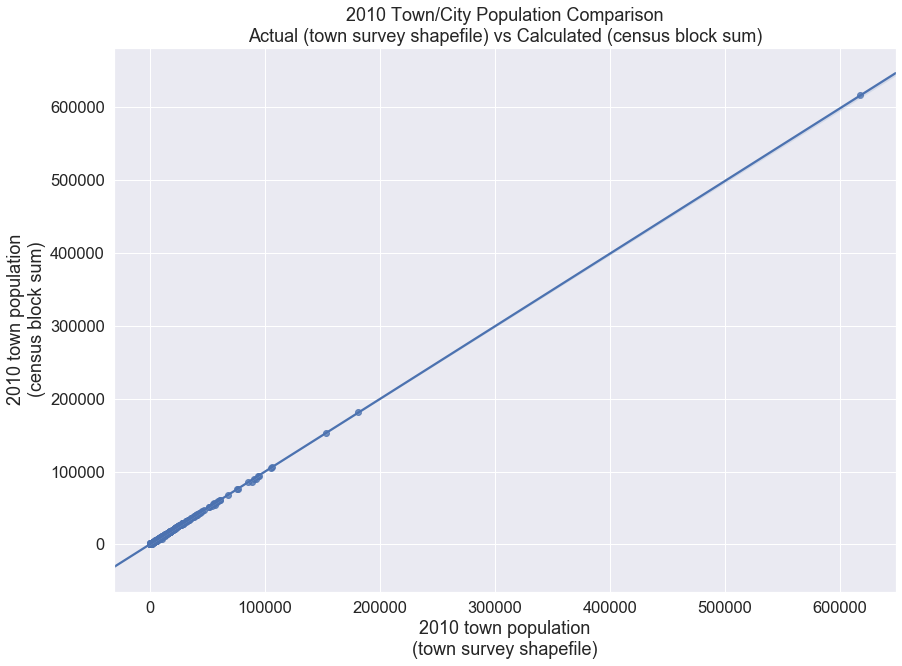

In [33]:
# plot result:
plt.figure(figsize=(14, 10))
sns.regplot(x='POP2010', y='POP100_RE', data=cent_join_sum_to_exp)
plt.xlabel('2010 town population\n(town survey shapefile)') 
plt.ylabel('2010 town population\n(census block sum)')
plt.title('2010 Town/City Population Comparison\nActual (town survey shapefile) vs Calculated (census block sum)')
plt.show()

Towns/cities with high populations dominate the plot - convert to square root to change scale

In [34]:
cent_join_sum_sqrt = cent_join_sum_to_exp.copy()
cent_join_sum_sqrt.set_index('TOWN', inplace=True)
cent_join_sum_sqrt = cent_join_sum_sqrt.apply(np.sqrt)
cent_join_sum_sqrt.head()

,POP2010,POP100_RE
TOWN,,
wellesley,167.278211,167.278211
needham,169.958819,169.958819
petersham,35.128336,35.128336
reading,157.311792,157.311792
quincy,303.761420,299.504591


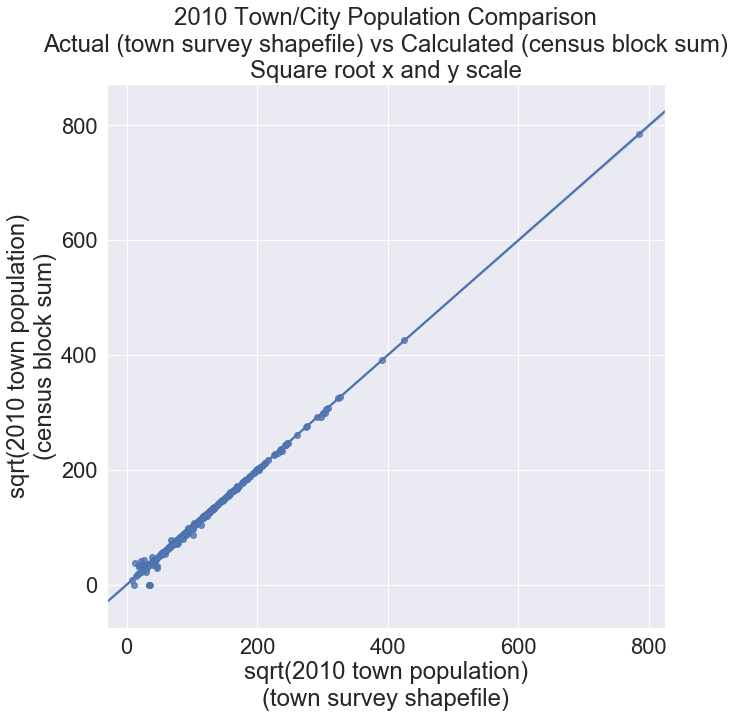

In [36]:
# plot result:
sns.set(font_scale=2)
plt.figure(figsize=(10, 10))
sns.regplot(x='POP2010', y='POP100_RE', data=cent_join_sum_sqrt)
plt.xlabel('sqrt(2010 town population)\n(town survey shapefile)') 
plt.ylabel('sqrt(2010 town population)\n(census block sum)')
plt.title('2010 Town/City Population Comparison\nActual (town survey shapefile) vs Calculated (census block sum)\nSquare root x and y scale')
plt.show()

Some towns with low populations seem to have pretty large errors

In [37]:
sns.set(font_scale=1.5)
cent_join_sum_to_exp['error'] = cent_join_sum_to_exp['POP100_RE'] - cent_join_sum_to_exp['POP2010']
cent_join_sum_to_exp['percent_error'] = (abs(cent_join_sum_to_exp['POP100_RE'] - cent_join_sum_to_exp['POP2010']) * 100) / cent_join_sum_to_exp['POP2010']
display(cent_join_sum_to_exp.sort_values('error', ascending=False))
display(cent_join_sum_to_exp.sort_values('percent_error', ascending=False))

,TOWN,POP2010,POP100_RE,error,percent_error
22,north brookfield,4680,6003.0,1323.0,28.269231
112,mount washington,167,1392.0,1225.0,733.532934
63,middlefield,521,1677.0,1156.0,221.880998
271,leyden,711,1822.0,1111.0,156.258790
52,marshfield,25132,26097.0,965.0,3.839726
...,...,...,...,...,...
154,ipswich,13175,10919.0,-2256.0,17.123340
159,plymouth,56468,54143.0,-2325.0,4.117376
4,quincy,92271,89703.0,-2568.0,2.783106
114,hull,10293,7584.0,-2709.0,26.318857


,TOWN,POP2010,POP100_RE,error,percent_error
112,mount washington,167,1392.0,1225.0,733.532934
63,middlefield,521,1677.0,1156.0,221.880998
62,rowe,393,1220.0,827.0,210.432570
59,hawley,337,897.0,560.0,166.172107
271,leyden,711,1822.0,1111.0,156.258790
...,...,...,...,...,...
129,brewster,9820,9820.0,0.0,0.000000
126,florida,752,752.0,0.0,0.000000
124,belchertown,14649,14649.0,0.0,0.000000
123,marlborough,38499,38499.0,0.0,0.000000


In [38]:
# average percent error and distributions:
cent_join_sum_to_exp[['error', 'percent_error']].describe()

,error,percent_error
count,351.000000,351.000000
mean,-73.572650,7.051235
std,455.502353,45.602087
min,-3861.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1323.000000,733.532934


In [43]:
# towns with errors:
sum(cent_join_sum_to_exp['percent_error'] > 0)

52

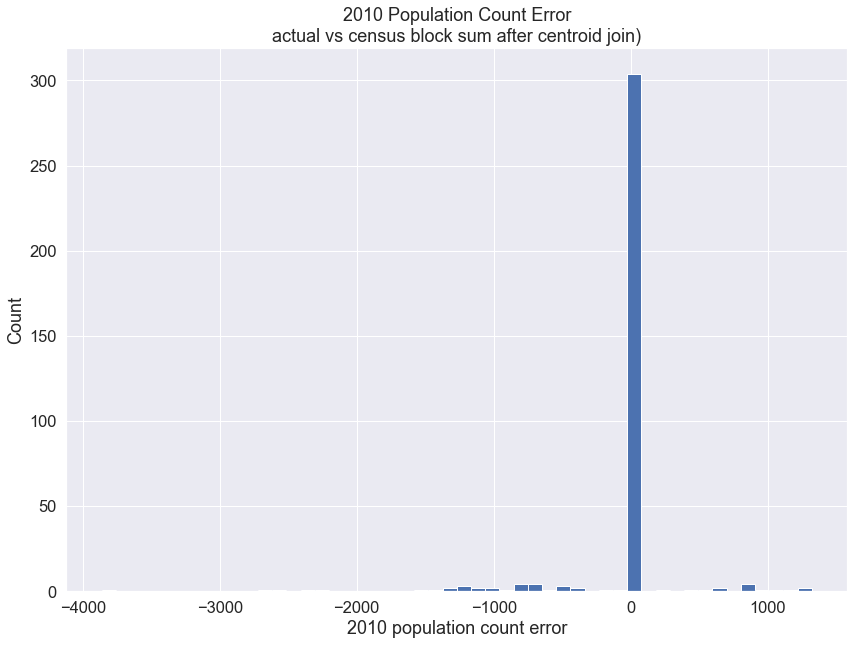

In [39]:
plt.figure(figsize=(14,10))
cent_join_sum_to_exp['error'].hist(bins=50)
plt.xlabel('2010 population count error')
plt.ylabel('Count')
plt.title('2010 Population Count Error\nactual vs census block sum after centroid join)')
plt.show()

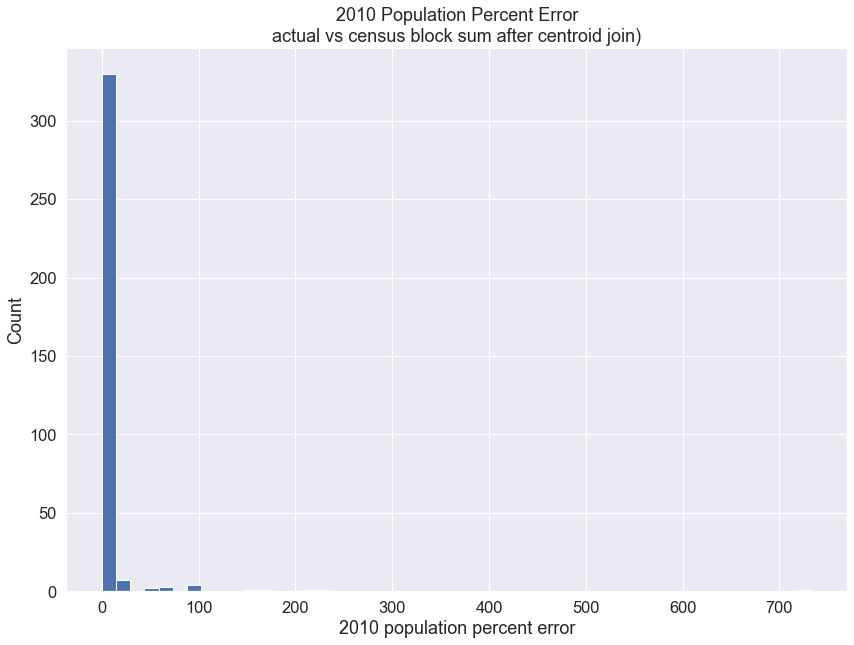

In [40]:
plt.figure(figsize=(14,10))
cent_join_sum_to_exp['percent_error'].hist(bins=50)
plt.xlabel('2010 population percent error')
plt.ylabel('Count')
plt.title('2010 Population Percent Error\nactual vs census block sum after centroid join)')
plt.show()

In [44]:
# towns with over 5% population count error after centroid merge:
print(cent_join_sum_to_exp[cent_join_sum_to_exp['percent_error'] > 5].shape)
cent_join_sum_to_exp[cent_join_sum_to_exp['percent_error'] > 5].sort_values('percent_error', ascending=False)

(31, 5)


,TOWN,POP2010,POP100_RE,error,percent_error
112,mount washington,167,1392.0,1225.0,733.532934
63,middlefield,521,1677.0,1156.0,221.880998
62,rowe,393,1220.0,827.0,210.432570
59,hawley,337,897.0,560.0,166.172107
271,leyden,711,1822.0,1111.0,156.258790
179,charlemont,1266,0.0,-1266.0,100.000000
38,egremont,1225,0.0,-1225.0,100.000000
264,monroe,121,0.0,-121.0,100.000000
127,worthington,1156,0.0,-1156.0,100.000000
282,heath,706,1182.0,476.0,67.422096


In [45]:
len(cent_join_sum_to_exp[cent_join_sum_to_exp['error'] != 0]['TOWN'])

52

In [46]:
cent_join_sub.head()

,TOWN,POP2010,SHAPE_Area,GEOID10,SHAPE_AREA,POP100_RE
0,wellesley,27982,2.726958e+07,250214041003,6.424854e+05,935.0
0,wellesley,27982,2.726958e+07,250214042012,1.167837e+06,989.0
0,wellesley,27982,2.726958e+07,250214042013,1.182595e+06,968.0
0,wellesley,27982,2.726958e+07,250214041002,1.079832e+06,1145.0
0,wellesley,27982,2.726958e+07,250214042014,5.306549e+05,664.0


In [47]:
cent_join_to_export = cent_join_sub[['TOWN', 'GEOID10']].copy()
cent_join_to_export['TOWN'] = cent_join_to_export['TOWN'].str.lower()
cent_join_to_export.head()

,TOWN,GEOID10
0,wellesley,250214041003
0,wellesley,250214042012
0,wellesley,250214042013
0,wellesley,250214041002
0,wellesley,250214042014


In [48]:
cent_join_sum_to_exp.columns = ['TOWN', 'town_actual_2010_pop', 'block_est_2010_pop', 'count_error', 'percent_error']
cent_join_sum_to_exp.head()

,TOWN,town_actual_2010_pop,block_est_2010_pop,count_error,percent_error
0,wellesley,27982,27982.0,0.0,0.000000
1,needham,28886,28886.0,0.0,0.000000
2,petersham,1234,1234.0,0.0,0.000000
3,reading,24747,24747.0,0.0,0.000000
4,quincy,92271,89703.0,-2568.0,2.783106


In [ ]:
#cent_join_to_export.to_csv("../../data/tidy_data/census_block_town_match.csv", index=False)
#cent_join_sum_to_exp.to_csv("../../data/tidy_data/census_block_town_match_2010pop_error.csv", index=False)